In [1]:
import numpy as np
import matplotlib.pyplot as plt

from adabmDCA.dataset import DatasetDCA
from adabmDCA.utils import init_chains
from adabmDCA.fasta import get_tokens
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
path_log_old = "/home/lorenzo/Documents/models/proteorhodopsin/old_sampling.log"
path_log_new = "/home/lorenzo/Documents/models/proteorhodopsin/new_sampling.log"
path_log_new_metropolis = "/home/lorenzo/Documents/models/proteorhodopsin/new_sampling_metropolis.log"

def get_logs(fname: str):
    with open(fname, "r") as f:
        start_collecting = False
        logs = {}
        for line in f:
            if line.startswith("Epochs"):
                keys = line.strip().split()
                logs = {key: [] for key in keys}
                start_collecting = True
                continue
            if start_collecting:
                values = line.strip().split()
                for key, value in zip(keys, values):
                    logs[key].append(float(value))
    return logs

In [18]:
logs_old = get_logs(path_log_old)
logs_new = get_logs(path_log_new)
logs_new_metropolis = get_logs(path_log_new_metropolis)

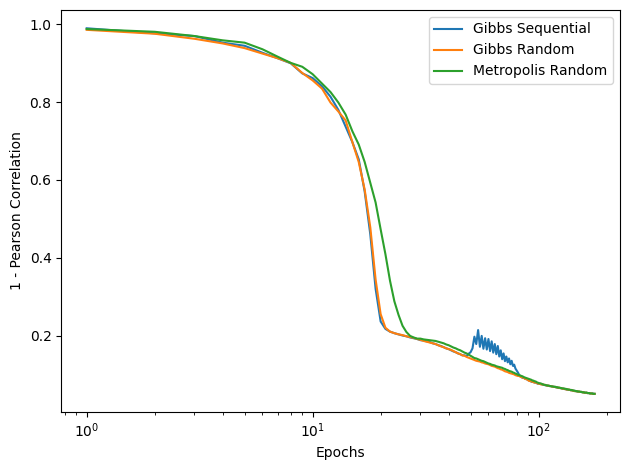

In [23]:
fig = plt.figure(dpi=100)
plt.plot(logs_old["Epochs"], 1 - np.array(logs_old["Pearson"]), label="Gibbs Sequential")
plt.plot(logs_new["Epochs"], 1 - np.array(logs_new["Pearson"]), label="Gibbs Random")
plt.plot(logs_new_metropolis["Epochs"], 1 - np.array(logs_new_metropolis["Pearson"]), label="Metropolis Random")
plt.xlabel("Epochs")
plt.ylabel("1 - Pearson Correlation")
plt.xscale("log")
plt.legend()
plt.tight_layout()

In [39]:
from typing import Tuple
import torch
import numpy as np

def get_seqid(
    s1: torch.Tensor,
    s2: torch.Tensor | None = None,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    - If s2 is provided, computes the mean and the standard deviation of the mean sequence identity between two sets of one-hot encoded sequences.
    - If s2 is a single sequence (L, q), it computes the mean and the standard deviation of the mean sequence identity between the dataset s1 and s2.
    - If s2 is none, computes the mean and the standard deviation of the mean of the sequence identity between s1 and a permutation of s1.

    Args:
        s1 (torch.Tensor): Sequence dataset 1.
        s2 (torch.Tensor | None): Sequence dataset 2. Defaults to None.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Mean sequence identity and standard deviation of the mean.
    """
    if len(s1.shape) == 2:
        s1 = s1.unsqueeze(0)
    if s2 is None:
        s2 = s1[torch.randperm(s1.shape[0])]
    if len(s2.shape) == 2:
        s2 = s2.unsqueeze(0)
        
    s1 = s1.view(s1.shape[0], -1)
    s2 = s2.view(s2.shape[0], -1)
    
    seqids = (s1 * s2).sum(1)
    mean_seqid = seqids.mean()
    if len(seqids) == 1:
        std_seqid = torch.tensor(0.0, device=seqids.device)
    else:
        std_seqid = seqids.std() / np.sqrt(len(seqids))

    return mean_seqid, std_seqid

In [40]:
chains = init_chains(1000, 112, 21, device)

In [49]:
msid, stdsid = get_seqid(chains[1], chains[29:56])
print(f"Mean sequence identity: {msid.item():.4f} ± {stdsid.item():.4f}")

Mean sequence identity: 5.4444 ± 0.4347


In [38]:
chains[1:30].shape

torch.Size([29, 112, 21])